- Cities - Berlin, Germany; Stockholm, Sweden; Klaipeda, Lithuania; Paris, France;

In [1]:
cities = {
'Berlin, Germany' : 'Q64',
'Stockholm, Sweden' : 'Q1754', 
'Klaipeda, Lithuania': 'Q776965', 
'Paris, France' : 'Q90'}

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import requests
import psycopg2
import networkx as nx
import matplotlib.pyplot as plt
import json

from time import sleep
from backoff import expo # type: ignore
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from PIL import Image
from diskcache import Cache
from geopy.distance import great_circle
from psycopg2.extras import execute_batch
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
from mpi4py.futures import MPIPoolExecutor, as_completed
from concurrent.futures import ThreadPoolExecutor

In [4]:
cache = Cache("cache")

# Task 1
Collect images about POIs of the cities. Atleast 1000 objects with images.

In [5]:
tags = {
    "amenity": [
        "Q11707",  # Restaurant
        "Q131708",  # Pharmacy
        "Q625802",  # Bar
        "Q189004",  # Pub
        "Q483453",  # Fountain
        "Q13226383",  # Marketplace
        "Q24354",  # Theatre
        "Q41253",  # Cinema
        "Q42814"  # Nightclub
    ],
    "cultural": [
        "Q2977",  # Cathedral
        "Q44539",  # Chapel
        "Q839954",  # Historic House
        "Q543654",  # Palace
        "Q3947",  # Town Hall
        "Q33506",  # Museum
        "Q1007870",  # Art Gallery
        "Q2040040",  # Resort
        "Q429014",  # Opera House
        "Q1966608",  # Concert Hall
        "Q1116285"  # Music Venue
    ],
    "outdoor": [
        "Q287",  # Hiking
        "Q3198785",  # Cross-country Skiing Track
        "Q159675",  # Trail
        "Q22698",  # Park
        "Q1107656",  # Garden
        "Q207694",  # Viewpoint
        "Q191067",  # Sauna
        "Q2542000",  # Nature Reserve
        "Q40080",  # Beach
        "Q48852",  # Botanical Garden
        "Q4421",  # Forest
        "Q23397",  # Lake
        "Q4022",  # River
        "Q46169"  # National Park
    ],
    "modern_attractions": [
        "Q30022",  # Science Museum
        "Q1027879",  # Planetarium
        "Q1841883",  # Aquarium
        "Q7213356",  # Entertainment Center
        "Q33506",  # Amusement Park
        "Q43501"  # Zoo
    ],
    "educational": [
        "Q3918",  # University
        "Q7075"  # Library
    ],
    "health_wellness": [
        "Q9364",  # Spa
        "Q16917",  # Hospital
        "Q27349",  # Dentist
        "Q102496",  # Laboratory
        "Q217602",  # Psychotherapist
        "Q169193",  # Rehabilitation
        "Q1325552",  # Social Facility
        "Q483394",  # Fitness Centre
        "Q6331535",  # Yoga Studio
        "Q6564857"  # Massage Parlor
    ],
    "shop": [
        "Q15061650",  # Supermarket
        "Q213441",  # Clothing Store
        "Q812843",  # Hairdresser
        "Q2747459",  # Bakery
        "Q660389",  # Butcher Shop
        "Q1326675",  # Furniture Store
        "Q18340514",  # Electronics Store
        "Q2059707",  # Florist
        "Q131734",  # Shopping Mall
        "Q161439",  # Jewelry Store
        "Q38984",  # Bookstore
        "Q13226383",  # Market
        "Q55825"  # Antique Shop
    ],
    "tourism": [
        "Q27686",  # Hotel
        "Q43501",  # Zoo
        "Q194195",  # Theme Park
        "Q570116",  # Tourist Attraction
        "Q207694",  # Viewpoint
        "Q2040040",  # Resort
        "Q306865",  # Guest House
        "Q929830",  # Bed and Breakfast
        "Q1085991"  # Campsite
    ],
    "leisure": [
        "Q1076486",  # Sports Centre
        "Q483110",  # Stadium
        "Q1893682",  # Firepit
        "Q2512229",  # Fishing
        "Q191067",  # Sauna
        "Q190103",  # Bowling Alley
        "Q20675753"  # Escape Room
    ],
    "sport": [
        "Q8063",  # Golf Course
        "Q3197620",  # Swimming Pool
        "Q1073650",  # Tennis Court
        "Q857060",  # Basketball Court
        "Q16996660",  # Volleyball Court
        "Q204664",  # Ice Rink
        "Q1350910"  # Skate Park
    ],
    "historic": [
        "Q5003624",  # Memorial
        "Q109607",  # Ruins
        "Q381885",  # Tomb
        "Q4989906",  # Monument
        "Q23413",  # Castle
        "Q2143829",  # Wayside Shrine
        "Q243830",  # Manor House
        "Q16970",  # Church
        "Q1808571",  # Barracks
        "Q41176",  # Bunker
        "Q12518",  # Tower
        "Q1293033",  # Fort
        "Q12280"  # Bridge
    ],
    "office": [
        "Q189188",  # Tourism Office
        "Q27686",  # Travel Agency
        "Q7210356",  # Government Office
        "Q43148",  # Insurance Company
        "Q192815"  # Estate Agent
    ],
    "waterway": [
        "Q47521",  # Stream
        "Q12323",  # Dam
        "Q43483",  # Well
        "Q34038",  # Waterfall
        "Q820532",  # Artificial Waterway
        "Q920333",  # Landmark
        "Q2413192",  # Soakhole
        "Q834194"  # Boatyard
    ]
}


def FilterQ():
    typeList = []
    for category in tags.values():
        typeList.extend([f'wd:{typeCode}' for typeCode in category])
    return ', '.join(typeList)

def ConstructQuery(cityQCode):
    tagFilter = FilterQ()
    queryTemplate = f"""
    SELECT DISTINCT ?place ?placeLabel ?typeLabel ?coordinates ?image WHERE {{
    SERVICE wikibase:label {{ bd:serviceParam wikibase:language "auto,en". }}
    ?place wdt:P31/wdt:P279* ?type; wdt:P625 ?coordinates.
    OPTIONAL {{ ?place wdt:P18 ?image. }}
    OPTIONAL {{ ?type rdfs:label ?typeLabel FILTER(LANG(?typeLabel) = "en") }}
    {{
        ?place wdt:P131+ wd:{cityQCode}.
    }}
    FILTER (?type in ({tagFilter}))
     }}
     LIMIT 2500
     """
    return queryTemplate

In [6]:
url = 'https://query.wikidata.org/sparql'

# Sometimes returns err code 500, change later
def fetchWikidataPois(city, cityQCode, retries=5, delay=2):
    query = ConstructQuery(cityQCode)
    for attempt in range(retries):
        try:
            response = requests.get(url, params={'query': query, 'format': 'json'})
            response.raise_for_status()
            data = response.json().get('results', {}).get('bindings', [])
            print(f'Fetched {len(data)} POIs for {city} on attempt {attempt + 1}')
            return processResults(data, city)
        except (requests.RequestException, ValueError) as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            sleep(delay)
    print(f"All attempts failed for city: {city}")
    return []

def processResults(data, city):
    results = []
    for item in data:
        coords = item.get('coordinates', {}).get('value', '').replace('Point(', '').replace(')', '').split(' ')
        results.append({
            'name': item.get('placeLabel', {}).get('value', ''),
            'latitude': coords[1] if len(coords) > 1 else None,
            'longitude': coords[0] if len(coords) > 1 else None,
            'city': city,
            'type': item.get('typeLabel', {}).get('value', ''),
            'image': item.get('image', {}).get('value', None)
        })
    return results

def collectAllPois():
    allPlaces = []
    with ThreadPoolExecutor(max_workers=len(cities)) as executor:
        futures = {executor.submit(fetchWikidataPois, city, qCode): city for city, qCode in cities.items()}
        for future in futures:
            allPlaces.extend(future.result())
    return pd.DataFrame(allPlaces)

dfRaw = collectAllPois()
print(dfRaw.head())

Fetched 98 POIs for Klaipeda, Lithuania on attempt 1
Fetched 457 POIs for Stockholm, Sweden on attempt 1
Fetched 2500 POIs for Berlin, Germany on attempt 1
Fetched 2500 POIs for Paris, France on attempt 1
                        name latitude longitude             city  \
0                   Q1454506  52.5399   13.2167  Berlin, Germany   
1  Embassy of Sweden, Berlin  52.5091   13.3509  Berlin, Germany   
2                 Franz-Club  52.5383   13.4128  Berlin, Germany   
3               Leipzig Gate  52.5122   13.3997  Berlin, Germany   
4                Lindencorso  52.5167   13.3896  Berlin, Germany   

                     type                                              image  
0                building                                               None  
1  political organization  http://commons.wikimedia.org/wiki/Special:File...  
2                building  http://commons.wikimedia.org/wiki/Special:File...  
3                facility  http://commons.wikimedia.org/wiki/Special:F

In [7]:
url = "https://en.wikipedia.org/w/api.php"
id_cols = ['name', 'city', 'latitude', 'longitude']

dfRaw = dfRaw[dfRaw['image'].notna()]
dfRaw = dfRaw.drop_duplicates(id_cols)
dfRaw = dfRaw.loc[:, dfRaw.isnull().mean() * 100 < 50]

@cache.memoize()
def GetImageCount(title: str) -> int:
    params = {
        "action": "query",
        "prop": "images",
        "titles": title,
        "format": "json"
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Ensure request was successful
        data = response.json()
        page = next(iter(data["query"]["pages"].values()))
        image_count = len(page.get("images", [])) if 'images' in page else 0
        return image_count
    except Exception as e:
        print(f"Error fetching image count for {title}: {e}")
        return 0

@cache.memoize()
def GetLinkCount(title: str) -> int:
    params = {
        "action": "query",
        "prop": "links",
        "titles": title,
        "pllimit": "max",
        "format": "json"
    }
    try:
        total_links = 0
        while True:
            response = requests.get(url, params=params)
            response.raise_for_status()  # Ensure request was successful
            data = response.json()
            page = next(iter(data["query"]["pages"].values()))
            total_links += len(page.get("links", [])) if 'links' in page else 0
            if 'continue' in data:
                params.update(data['continue'])
            else:
                break
        return total_links
    except Exception as e:
        print(f"Error fetching link count for {title}: {e}")
        return 0

@cache.memoize()
def GetPageSize(title: str) -> int:
    params = {
        "action": "query",
        "prop": "info",
        "titles": title,
        "inprop": "protection",
        "format": "json"
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Ensure request was successful
        data = response.json()
        page = next(iter(data["query"]["pages"].values()))
        length = page.get("length", 0)
        return length
    except Exception as e:
        print(f"Error fetching page size for {title}: {e}")
        return 0

@cache.memoize()
def GetReferencesCount(title: str) -> int:
    settings = {
        "titles": title,
        "prop": "extlinks",
        "action": "query",
        "format": "json",
        "ellimit": "max"
    }
    references_count = 0
    try:
        while True:
            response = requests.get(url, params=settings)
            response.raise_for_status()  # Ensure request was successful
            data = response.json()
            page = next(iter(data["query"]["pages"].values()))
            references = page.get("extlinks", [])
            references_count += len(references)
            if 'continue' in data:
                settings['eloffset'] = data['continue']['eloffset']
            else:
                break
        return references_count
    except Exception as ex:
        print(f"Error fetching references count for {title}: {ex}")
        return 0

@cache.memoize()
def GetRevisionCount(title: str) -> int:
    params = {
        "action": "query",
        "prop": "revisions",
        "titles": title,
        "rvlimit": "max",
        "format": "json"
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Ensure request was successful
        data = response.json()
        page = next(iter(data["query"]["pages"].values()))
        revision_count = len(page.get("revisions", [])) if 'revisions' in page else 0
        return revision_count
    except Exception as e:
        print(f"Error fetching revision count for {title}: {e}")
        return 0

@cache.memoize()
def GetViewCount(title: str) -> float:
    params = {
        "action": "query",
        "prop": "pageviews",
        "titles": title,
        "format": "json"
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Ensure request was successful
        data = response.json()
        pageviews_data = data["query"]["pages"].popitem()[1]["pageviews"]
        total_views = sum(views for views in pageviews_data.values() if views is not None)
        return total_views
    except Exception as ex:
        print(f"Error fetching view count for {title}: {ex}")
        return 0.0

def NewColumns(function, df, column_name, num_of_workers=100):
    split_dfs = np.array_split(df, num_of_workers)
    results = [None] * len(df)
    
    print(f"Current function '{function.__name__}'")
    
    with ThreadPoolExecutor(max_workers=num_of_workers) as executor:
        futures_to_index = {}
        current_index = 0

        for split_df in split_dfs:
            for index, row in split_df.iterrows():
                futures_to_index[executor.submit(function, row[column_name])] = current_index
                current_index += 1
        
        for future in as_completed(futures_to_index):
            index = futures_to_index[future]
            try:
                results[index] = future.result()
            except Exception as e:
                print(f"Error on row {index}: {e}")
                results[index] = None
    
    print("Done.") 
    return results

weights = {
    'view_count': 0.4,  
    'page_size': 0.2,     
    'link_count': 0.1,        
    'image_count': 0.1,        
    'revision_count': 0.1,         
    'references_count': 0.1
}

def calculate_relevance_score(row, weights):
    score = 0
    for feature, weight in weights.items():
        score += row[feature] * weight
    return score

dfRaw['image_count'] = NewColumns(GetImageCount, dfRaw, 'name')
dfRaw['link_count'] = NewColumns(GetLinkCount, dfRaw, 'name')
dfRaw['page_size'] = NewColumns(GetPageSize, dfRaw, 'name')
dfRaw['references_count'] = NewColumns(GetReferencesCount, dfRaw, 'name')
dfRaw['revision_count'] = NewColumns(GetRevisionCount, dfRaw, 'name')
dfRaw['view_count'] = NewColumns(GetViewCount, dfRaw, 'name')
dfRaw['relevance_score'] = dfRaw.apply(lambda row: calculate_relevance_score(row, weights), axis=1)
max_score = dfRaw['relevance_score'].max()
min_score = dfRaw['relevance_score'].min()
dfRaw['relevance_score'] = (dfRaw['relevance_score'] - min_score) / (max_score - min_score)
dfRaw.head()

Current function 'GetImageCount'
Done.
Current function 'GetLinkCount'
Done.
Current function 'GetPageSize'
Done.
Current function 'GetReferencesCount'
Done.
Current function 'GetRevisionCount'
Done.
Current function 'GetViewCount'
Error fetching view count for Q120716618: 'query'
Error fetching view count for Gutshaus Carstenns Schlösschen Lichterfelde: 'query'
Error fetching view count for Q117705755: 'query'
Error fetching view count for Reichard & Lindner: 'query'
Error fetching view count for Medical Library of the Charité – Universitätsmedizin: 'query'
Error fetching view count for Adolf-Martens-Straße 14: 'query'
Error fetching view count for Rhinstraße/Plauener Straße (tram stop): 'query'
Error fetching view count for Q119397183: 'query'
Error fetching view count for Campus Benjamin Franklin: 'query'
Error fetching view count for Q120644569: 'query'
Error fetching view count for Friedhof Zum Heiligen Kreuz: 'query'
Error fetching view count for Q28739286: 'query'
Error fetching

,name,latitude,longitude,city,type,image,image_count,link_count,page_size,references_count,revision_count,view_count,relevance_score
1,"Embassy of Sweden, Berlin",52.5091,13.3509,"Berlin, Germany",political organization,http://commons.wikimedia.org/wiki/Special:File...,10,283,18426,22,21,174.0,0.072842
2,Franz-Club,52.5383,13.4128,"Berlin, Germany",building,http://commons.wikimedia.org/wiki/Special:File...,0,0,0,0,0,0.0,0.000000
3,Leipzig Gate,52.5122,13.3997,"Berlin, Germany",facility,http://commons.wikimedia.org/wiki/Special:File...,0,0,0,0,0,0.0,0.000000
4,Lindencorso,52.5167,13.3896,"Berlin, Germany",building,http://commons.wikimedia.org/wiki/Special:File...,0,0,0,0,0,0.0,0.000000
7,Fredersdorfer Mühlenfließ,52.438531,13.6775,"Berlin, Germany",river,http://commons.wikimedia.org/wiki/Special:File...,3,21,1442,5,18,22.0,0.005805


# Data quality report

Drop rows with N/A values and dupes

In [8]:
id_cols = ['name', 'city', 'latitude', 'longitude']

df = dfRaw[dfRaw['image'].notna()]
df = df.drop_duplicates(id_cols)
df = df.loc[:, df.isnull().mean() * 100 < 50]

categorical_cols = df.select_dtypes(exclude=['int64', 'float64']).columns
continuous_cols = df.select_dtypes(include=['int64', 'float64']).columns

print(f"Continuous features ({len(continuous_cols)}): ", *continuous_cols)
print(f"Categorical features ({len(categorical_cols)}): ", *categorical_cols)
city_image_counts = df['city'].value_counts()

print("Image Count per City:")
print(city_image_counts)

Continuous features (7):  image_count link_count page_size references_count revision_count view_count relevance_score
Categorical features (6):  name latitude longitude city type image
Image Count per City:
city
Berlin, Germany        854
Paris, France          364
Stockholm, Sweden      136
Klaipeda, Lithuania     30
Name: count, dtype: int64


# Task 2

Apply K-means algorithm for extraction of dominant colors. Sort the clusters based on the number of assigned points in decreasing order. (Format feature vector of Kx3 numerical values, here 1-3 positions represent the centroid of largest cluster (RGB), the last 3 positions represent the centroid of smallest cluster (RGB)). (4 points).


# Download images

In [9]:
df = df[~df['name'].str.startswith('Q')]
df = df.groupby('city', group_keys=False).apply(lambda x: x.nlargest(200, 'relevance_score')).reset_index(drop=True)
for city in cities:
    print(f"Data size after processing {city:<20} {len(df[df['city'] == city]):>5} rows")

Data size after processing Berlin, Germany        200 rows
Data size after processing Stockholm, Sweden      129 rows
Data size after processing Klaipeda, Lithuania     30 rows
Data size after processing Paris, France          200 rows


In [10]:
def downloadImage(url, dir="imgs/"):
    if not os.path.exists(dir):
        os.makedirs(dir)
    try:
        imgName = os.path.basename(url)
        imgPath = os.path.join(dir, imgName)
        if os.path.exists(imgPath):
            return imgPath
        header = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
        }
        response = requests.get(url,headers=header)
        response.raise_for_status()
        with open(imgPath, 'wb') as file:
            file.write(response.content)
        print(f"Image downloaded {imgPath}")
        return imgPath
    except Exception as e:
        print(f"Error downloading image: {e}")
        return None
df['imgPath'] = df['image'].apply(downloadImage)
df


Image downloaded imgs/Clp%2020060514%20EKZ%20Storchenhof.jpg
Image downloaded imgs/Berlin-bvg-sl-4--736853.jpg
Image downloaded imgs/Charlottenburg%20Hohenzollern%202.jpg
Image downloaded imgs/Aerodynamic%20park%20Berlin%204.JPG
Image downloaded imgs/M%C3%A9morial%20du%20mur%20de%20Berlin%20%286330924243%29.jpg
Image downloaded imgs/Berlin%20Clayallee%20AlliiertenMuseum%20UAV%2004-2017.jpg
Image downloaded imgs/Berliner%20Mauer%201987%2000010034.jpg
Image downloaded imgs/Internationales%20Begegnungszentrum%20der%20Wissenschaft%20Berlin.jpg
Image downloaded imgs/PeterPaulNikolskoe.jpg
Image downloaded imgs/Bf-b-lichterfsued.jpg
Image downloaded imgs/120409-Steglitz-Kreisel.JPG
Image downloaded imgs/Bahnhof%20Berlin-Wannsee%20Empfangsgebaeude%2004-2015.jpg
Image downloaded imgs/Waldfriedhof%20Dahlem1%20Berlin.JPG
Image downloaded imgs/Reichstagsgeb%C3%A4ude%20von%20Westen.jpg
Image downloaded imgs/Prinz-Albrecht-Palais.jpg
Image downloaded imgs/Bhf.%20Mexikoplatz%20Berlin%20IMG%201169.jp

,name,latitude,longitude,city,type,image,image_count,link_count,page_size,references_count,revision_count,view_count,relevance_score,imgPath
0,Führerbunker,52.5125,13.3815,"Berlin, Germany",facility,http://commons.wikimedia.org/wiki/Special:File...,10,274,35614,17,500,109871.0,0.983522,imgs/Bundesarchiv%20Bild%20183-V04744%2C%20Ber...
1,Brandenburg Gate,52.516272222,13.377722222,"Berlin, Germany",facility,http://commons.wikimedia.org/wiki/Special:File...,10,287,39868,60,500,90263.0,0.849182,imgs/BrandenburgTor%20in%20early%20morning%20l...
2,E3,52.5316,13.4309,"Berlin, Germany",house,http://commons.wikimedia.org/wiki/Special:File...,10,210,80834,192,500,38320.0,0.607326,imgs/Holzhaus%20Esmarchstra%C3%9Fe%203%20%28sc...
3,Humboldt University of Berlin,52.518055555,13.393333333,"Berlin, Germany",university,http://commons.wikimedia.org/wiki/Special:File...,10,521,62553,100,500,26622.0,0.447477,imgs/Berlin%2C%20Mitte%2C%20Unter%20den%20Lind...
4,Savoy Hotel,52.5061,13.3275,"Berlin, Germany",hotel,http://commons.wikimedia.org/wiki/Special:File...,10,329,63700,117,500,25465.0,0.442652,imgs/Savoy%20Hotel%20Berlin.JPG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,Djursborg,59.33833333,18.09,"Stockholm, Sweden",building,http://commons.wikimedia.org/wiki/Special:File...,0,0,0,0,0,0.0,0.000000,imgs/Djursborg%201909.jpg
555,Katarina gångbro,59.319047222,18.073527777,"Stockholm, Sweden",bridge,http://commons.wikimedia.org/wiki/Special:File...,0,0,0,0,0,0.0,0.000000,imgs/Katarina%20g%C3%A5ngbro%2C%20mars%202019b...
556,Hoard from Loshult Scania,56.490531,14.106978,"Stockholm, Sweden",archaeological site,http://commons.wikimedia.org/wiki/Special:File...,0,0,0,0,0,0.0,0.000000,imgs/SHM11217-22682%2001.jpg
557,Skärholmen stone circle,59.269206,17.89875,"Stockholm, Sweden",archaeological site,http://commons.wikimedia.org/wiki/Special:File...,0,0,0,0,0,0.0,0.000000,imgs/Domarringen%20Sk%C3%A4rholmen%202011.jpg


# Extract colors

In [11]:
@cache.memoize()
def extractDominant(imgPath, downscale=0.2):
    try:
        img = cv2.imread(imgPath)
        if img is None:
            raise ValueError(f"Image not found or cannot be opened: {imgPath}")
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (0, 0), fx=downscale, fy=downscale)
        img = img.reshape((-1, 3))
        return img
    except Exception as e:
        print(f"Error extracting dominant colors: {e}")
        return None

def extract_dominant_colors(image_path, k=4):
    pixels = extractDominant(image_path)
    if pixels is None:
        return None
    
    try:
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(pixels)
        cluster_centers = kmeans.cluster_centers_
        cluster_sizes = np.bincount(kmeans.labels_)
        sorted_clusters = cluster_centers[np.argsort(cluster_sizes)[::-1]]
        return sorted_clusters.flatten().tolist()
    except Exception as e:
        print(f"Error during KMeans fitting: {e}")
        return None

def process_image(image_path):
    return extract_dominant_colors(image_path)

image_paths = df['imgPath'].tolist()
dominant_colors_list = []

with ThreadPoolExecutor(max_workers=8) as executor:
    future_to_image = {executor.submit(process_image, imgPath): imgPath for imgPath in image_paths}
    for future in as_completed(future_to_image):
        image_path = future_to_image[future]
        try:
            dominant_colors = future.result()
            dominant_colors_list.append(dominant_colors)
        except Exception as exc:
            print(f'{image_path} generated an exception: {exc}')
            dominant_colors_list.append(None)

df['dominant_colors'] = dominant_colors_list
print(df.head())

c:\Users\Kompiuteris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


                            name      latitude     longitude             city  \
0                   Führerbunker       52.5125       13.3815  Berlin, Germany   
1               Brandenburg Gate  52.516272222  13.377722222  Berlin, Germany   
2                             E3       52.5316       13.4309  Berlin, Germany   
3  Humboldt University of Berlin  52.518055555  13.393333333  Berlin, Germany   
4                    Savoy Hotel       52.5061       13.3275  Berlin, Germany   

         type                                              image  image_count  \
0    facility  http://commons.wikimedia.org/wiki/Special:File...           10   
1    facility  http://commons.wikimedia.org/wiki/Special:File...           10   
2       house  http://commons.wikimedia.org/wiki/Special:File...           10   
3  university  http://commons.wikimedia.org/wiki/Special:File...           10   
4       hotel  http://commons.wikimedia.org/wiki/Special:File...           10   

   link_count  page_size  

# Show examples of dominant colors

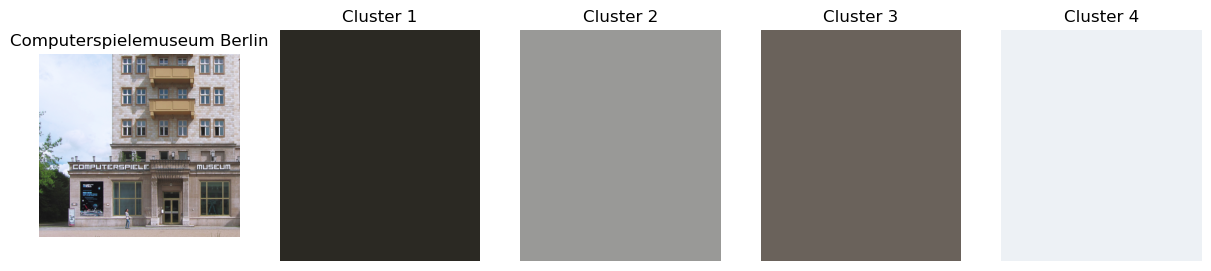

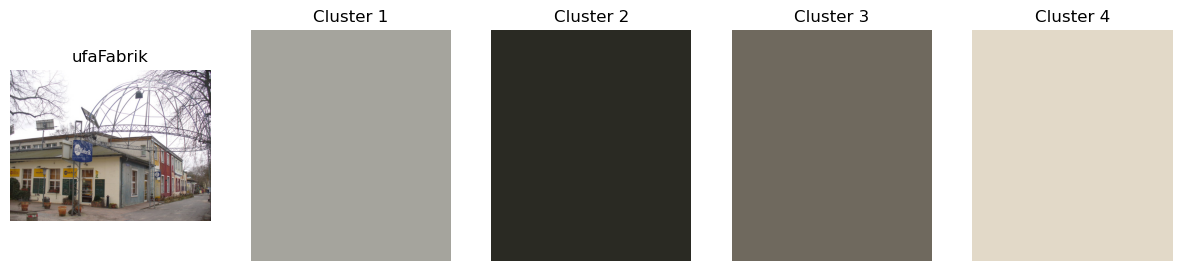

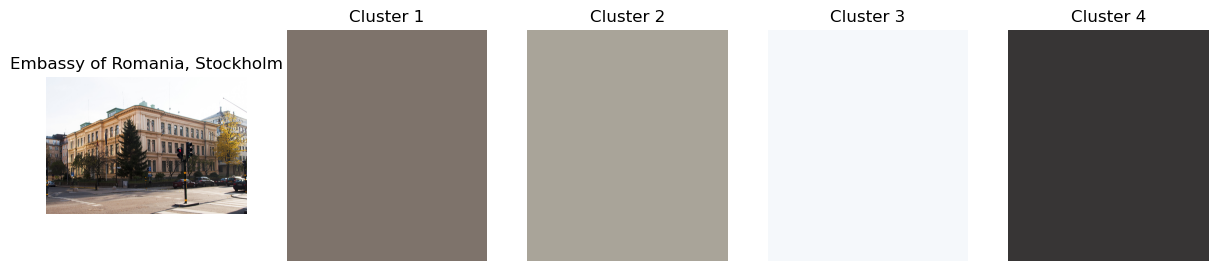

130    None
191    None
486    None
dtype: object

In [12]:
import matplotlib.image as mpimg

def displayColorPaletteAndImage(row):
    dominant_colors = row['dominant_colors']
    image_path = row['imgPath']
    clusters_rgb = np.array(dominant_colors).reshape(-1, 3)
    img = mpimg.imread(image_path)
    fig, ax = plt.subplots(1, len(clusters_rgb) + 1, figsize=(15, 3))
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title(row['name'])
    for i, color in enumerate(clusters_rgb):
        ax[i + 1].add_patch(plt.Rectangle((0, 0), 1, 1, color=color / 255))
        ax[i + 1].axis('off')
        ax[i + 1].set_title(f'Cluster {i+1}')
    plt.show()

df.sample(3).apply(displayColorPaletteAndImage, axis=1)

# Task 3

Apply similar places search by formatted vectors using KNN

In [13]:
def find_similar_places_by_vectors(row, N=5):
    selected_vector = row['dominant_colors']
    if not selected_vector:
        return []
    
    places_with_vectors = df.dropna(subset=['dominant_colors']).drop(index=row.name)
    if places_with_vectors.empty:
        return []

    try:
        X = np.vstack(places_with_vectors['dominant_colors'].apply(lambda x: np.array(x).flatten() if isinstance(x, list) else x).values)
        
        knn = NearestNeighbors(n_neighbors=N)
        knn.fit(X)
        
        distances, indices = knn.kneighbors(np.array(selected_vector).flatten().reshape(1, -1))
        similar_indices = places_with_vectors.iloc[indices[0]].index.tolist()
        similarity_scores = 1 / (1 + distances[0])
        similarity_scores = np.round(similarity_scores, 3)
        
        return list(zip(similar_indices, similarity_scores))
    except Exception as e:
        print(f"Error finding similar places: {e}")
        return []

df['similar_places'] = df.apply(find_similar_places_by_vectors, axis=1)
print(df.head())


features = df.loc[:, df.columns.difference(id_cols)].apply(pd.to_numeric, errors='coerce').dropna(axis=1)
kmeans = KMeans(n_clusters=8, n_init=10)
df['cluster'] = kmeans.fit_predict(features.values)

def find_similar_places(selected_place, N=5):
    same_cluster = df[(df['cluster'] == selected_place['cluster']) & (df.index != selected_place.name)]
    
    if same_cluster.empty or len(same_cluster) < N:
        return []

    features = same_cluster.loc[:, df.columns.difference(id_cols)].apply(pd.to_numeric, errors='coerce').dropna(axis=1)
    selected_features = selected_place[features.columns].values.reshape(1, -1)
    
    knn = NearestNeighbors(n_neighbors=N)
    knn.fit(features.values)
    
    distances, indices = knn.kneighbors(selected_features)
    similar_indices = same_cluster.iloc[indices[0]].index.tolist()
    similarity_scores = 1 / (1 + distances[0])
    similarity_scores = np.round(similarity_scores, 3)
    
    return list(zip(similar_indices, similarity_scores))

df['similar_places_by_data'] = df.apply(find_similar_places, axis=1)


                            name      latitude     longitude             city  \
0                   Führerbunker       52.5125       13.3815  Berlin, Germany   
1               Brandenburg Gate  52.516272222  13.377722222  Berlin, Germany   
2                             E3       52.5316       13.4309  Berlin, Germany   
3  Humboldt University of Berlin  52.518055555  13.393333333  Berlin, Germany   
4                    Savoy Hotel       52.5061       13.3275  Berlin, Germany   

         type                                              image  image_count  \
0    facility  http://commons.wikimedia.org/wiki/Special:File...           10   
1    facility  http://commons.wikimedia.org/wiki/Special:File...           10   
2       house  http://commons.wikimedia.org/wiki/Special:File...           10   
3  university  http://commons.wikimedia.org/wiki/Special:File...           10   
4       hotel  http://commons.wikimedia.org/wiki/Special:File...           10   

   link_count  page_size  

c:\Users\Kompiuteris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [14]:
import psycopg2
from psycopg2 import sql
from psycopg2.extras import execute_batch

# Database connection
conn = psycopg2.connect(dbname="", user="", password="", host="localhost", port="")
cur = conn.cursor()

# Schema and table creation
cur.execute("DROP SCHEMA IF EXISTS poi_data CASCADE;")
conn.commit()

schema_name = "poi_data"
cur.execute(sql.SQL("CREATE SCHEMA IF NOT EXISTS {}").format(sql.Identifier(schema_name)))
conn.commit()

# Create tables
cur.execute(sql.SQL("""
    CREATE TABLE IF NOT EXISTS poi_data.city (
        city_id SERIAL PRIMARY KEY,
        name VARCHAR(255) UNIQUE
    );
""").format(sql.Identifier(schema_name)))
cur.execute(sql.SQL("""
    CREATE TABLE IF NOT EXISTS poi_data.place (
        place_id SERIAL PRIMARY KEY,
        name VARCHAR(255),
        latitude DOUBLE PRECISION,
        longitude DOUBLE PRECISION,
        city_id INTEGER REFERENCES poi_data.city(city_id),
        type VARCHAR(255),
        image TEXT,
        image_count INTEGER,
        link_count INTEGER,
        page_size INTEGER,
        view_count INTEGER,
        relevance_score DOUBLE PRECISION
    );
""").format(sql.Identifier(schema_name)))
cur.execute(sql.SQL("""
    CREATE TABLE IF NOT EXISTS poi_data.category (
        category_id SERIAL PRIMARY KEY,
        name VARCHAR(255) UNIQUE
    );
""").format(sql.Identifier(schema_name)))
cur.execute(sql.SQL("""
    CREATE TABLE IF NOT EXISTS poi_data.place_category (
        place_id INTEGER REFERENCES poi_data.place(place_id),
        category_id INTEGER REFERENCES poi_data.category(category_id),
        PRIMARY KEY (place_id, category_id)
    );
""").format(sql.Identifier(schema_name)))
cur.execute(sql.SQL("""
    CREATE TABLE IF NOT EXISTS poi_data.similar_places_data (
        main_place_id INTEGER REFERENCES poi_data.place(place_id),
        similar_place_id INTEGER REFERENCES poi_data.place(place_id),
        sim_score DOUBLE PRECISION,
        PRIMARY KEY (main_place_id, similar_place_id)
    );
""").format(sql.Identifier(schema_name)))
cur.execute(sql.SQL("""
    CREATE TABLE IF NOT EXISTS poi_data.similar_places_colors (
        main_place_id INTEGER REFERENCES poi_data.place(place_id),
        similar_place_id INTEGER REFERENCES poi_data.place(place_id),
        sim_score DOUBLE PRECISION,
        PRIMARY KEY (main_place_id, similar_place_id)
    );
""").format(sql.Identifier(schema_name)))
conn.commit()

# Insert cities
city_query = sql.SQL("""
    INSERT INTO poi_data.city (name) VALUES (%s)
    ON CONFLICT (name) DO NOTHING RETURNING city_id;
""")
cities = df['city'].unique()
city_id_map = {}
for city in cities:
    cur.execute(city_query, (city,))
    result = cur.fetchone()
    if result:
        city_id_map[city] = result[0]
    else:
        cur.execute("SELECT city_id FROM poi_data.city WHERE name = %s", (city,))
        city_id_map[city] = cur.fetchone()[0]

# Insert places
place_query = sql.SQL("""
    INSERT INTO poi_data.place 
    (name, latitude, longitude, city_id, type, image, image_count, link_count, page_size, 
     view_count, relevance_score) 
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    RETURNING place_id;
""")
places = []
for index, row in df.iterrows():
    places.append((
        row['name'], row['latitude'], row['longitude'], city_id_map[row['city']], row['type'], row['image'], 
        row['image_count'], row['link_count'], row['page_size'], row['view_count'], 
        row['relevance_score']
    ))
place_id_map = {}
for place in places:
    cur.execute(place_query, place)
    place_id_map[place[0]] = cur.fetchone()[0]

# Insert categories
category_query = sql.SQL("""
    INSERT INTO poi_data.category (name) VALUES (%s)
    ON CONFLICT (name) DO NOTHING RETURNING category_id;
""")
categories = df['type'].unique()
category_id_map = {}
for category in categories:
    cur.execute(category_query, (category,))
    result = cur.fetchone()
    if result:
        category_id_map[category] = result[0]
    else:
        cur.execute("SELECT category_id FROM poi_data.category WHERE name = %s", (category,))
        category_id_map[category] = cur.fetchone()[0]

# Insert place-category relationships
place_category_query = sql.SQL("""
    INSERT INTO poi_data.place_category (place_id, category_id) VALUES (%s, %s)
    ON CONFLICT DO NOTHING;
""")
place_categories = []
for index, row in df.iterrows():
    place_id = place_id_map[row['name']]
    category_id = category_id_map[row['type']]
    place_categories.append((place_id, category_id))
execute_batch(cur, place_category_query, place_categories)
conn.commit()

# Insert similar places data
similar_places_query_data = sql.SQL("""
    INSERT INTO poi_data.similar_places_data (main_place_id, similar_place_id, sim_score) VALUES (%s, %s, %s)
    ON CONFLICT DO NOTHING;
""")
similar_places_data = []
for index, row in df.iterrows():
    main_place_id = place_id_map[row['name']]
    for similar_place_id, sim_score in row['similar_places_by_data']:
        similar_places_data.append((main_place_id, place_id_map[df.loc[similar_place_id, 'name']], sim_score))
execute_batch(cur, similar_places_query_data, similar_places_data)
conn.commit()

# Insert similar places colors
similar_places_query_colors = sql.SQL("""
    INSERT INTO poi_data.similar_places_colors (main_place_id, similar_place_id, sim_score) VALUES (%s, %s, %s)
    ON CONFLICT DO NOTHING;
""")
similar_places_colors = []
for index, row in df.iterrows():
    main_place_id = place_id_map[row['name']]
    for similar_place_id, sim_score in row['similar_places']:
        similar_places_colors.append((main_place_id, place_id_map[df.loc[similar_place_id, 'name']], sim_score))
execute_batch(cur, similar_places_query_colors, similar_places_colors)
conn.commit()

# Close cursor and connection
cur.close()
conn.close()